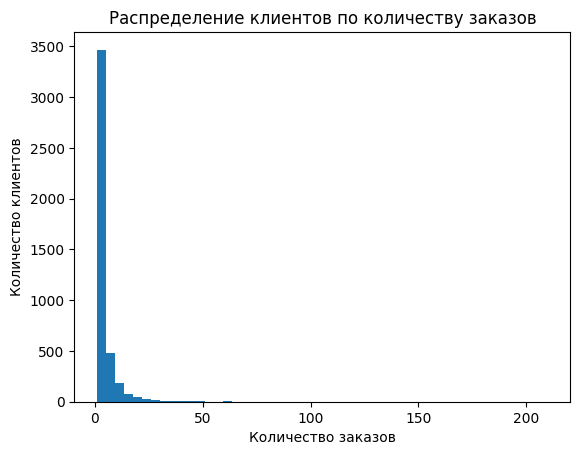

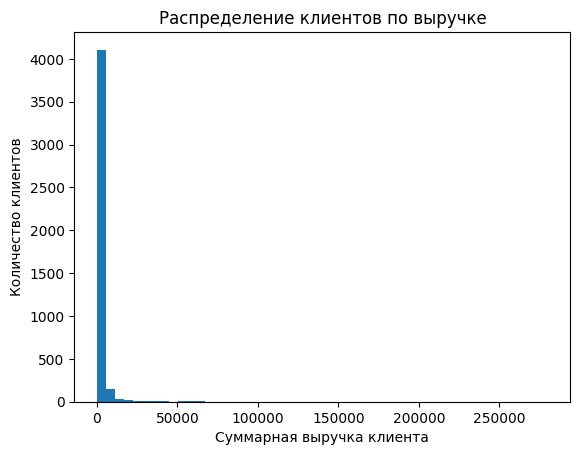

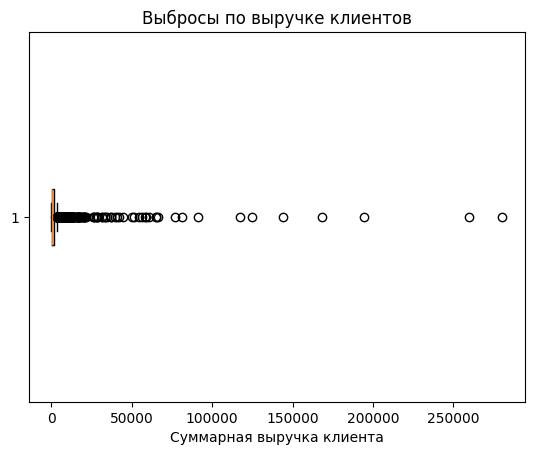

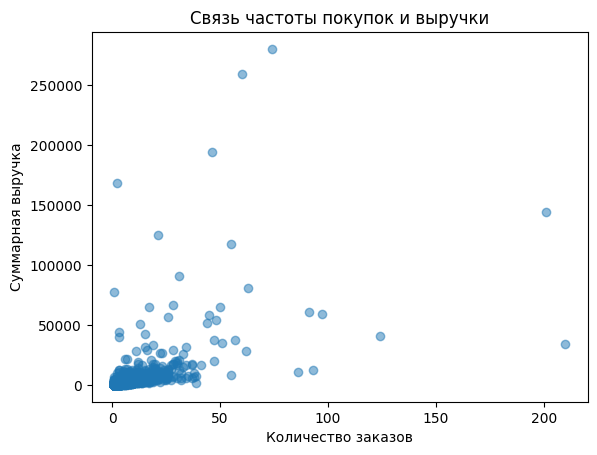

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


,recency,frequency,monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2053.793018
std,100.009747,7.705493,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,307.245000
50%,51.000000,2.000000,674.450000
75%,142.000000,5.000000,1661.640000
max,374.000000,210.000000,280206.020000


,CustomerID,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,12346.0,326,1,77183.60,1,1,5,115
1,12347.0,2,7,4310.00,5,5,5,555
2,12348.0,75,4,1797.24,2,4,4,244
3,12349.0,19,1,1757.55,4,1,4,414
4,12350.0,310,1,334.40,1,1,2,112


Segment
Regular    1821
Lost       1065
Loyal      1014
VIP         439
Name: count, dtype: int64

Segment
VIP        4040565.650
Loyal      2301649.901
Regular    2049783.781
Lost        519408.572
Name: monetary, dtype: float64

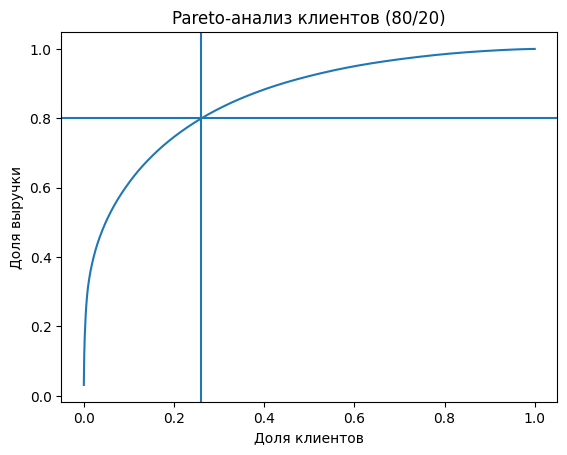

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


df = pd.read_csv('C:/Users/Admin/PycharmProjects/analytics/online_retail_analysis/data/online_retail.csv', encoding='windows-1251')

# df.head()
# Общая информация по данным
# df.info()

# Посчитает пропуски по каждой колонке
# df.isna().sum()

# 1. Первичная очистка данных

# Приводим дату к datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Убираем строки без CustomerID
df = df.dropna(subset=['CustomerID'])

# Оставляем только реальные покупки
df = df[df['Quantity'] > 0]

# добавляем значение выручки
df['Revenue'] = df['Quantity']*df['UnitPrice']

# df.info()

## Задача №1: Очистка данных

## В рамках подготовки данных:
## - колонка InvoiceDate приведена к типу datetime
## - удалены строки без CustomerID
## - исключены возвраты и отменённые заказы
## - рассчитана выручка по каждой позиции

# df.head()

# Шаг 1 - отделяем возвраты

returns = df[df['Quantity'] < 0]
sales = df[df['Quantity'] > 0]

returns.shape, sales.shape

# Данные о возвратах отсутствуют — после фильтрации датафрейм оказался пустым.
# Основной датасет продаж содержит 397 924 записи и 9 признаков, что позволяет проводить статистический и поведенческий анализ.

# Шаг 2 - базовая аггрегация по клиентам

## Cчитаем по каждому клиенту:
## - количество заказов
## - общую выручку
## - средний чек
## - период активности

client_metrics = (
    df.groupby('CustomerID').agg(
        orders_count = ('InvoiceNo', 'nunique'),
        total_revenue = ('Revenue', 'sum'),
        avg_check = ('Revenue', 'mean'),
        first_purchase = ('InvoiceDate', 'min'),
        last_purchase = ('InvoiceDate', 'max')
    )
    .reset_index()
)

client_metrics.head()

# Шаг 3 — добавить частоту покупок

# Cчитаем длину жизни клиента

client_metrics['lifetime_days'] = (
    client_metrics['last_purchase'] - client_metrics['first_purchase']
).dt.days + 1

#  Cчитаем частоту покупок

client_metrics['purchase_frequency'] = (
    client_metrics['orders_count'] / client_metrics['lifetime_days']
)

# Быстрая проверка распределений (без графиков)

client_metrics[['orders_count', 'total_revenue', 'purchase_frequency']].describe()

# Выводы:
## - Большинство клиентов совершают 1–2 покупки и приносят ограниченную выручку.
## - Основная доля выручки формируется небольшой группой клиентов с высокой частотой покупок и высоким суммарным чеком.
## - Распределения заказов и выручки сильно асимметричны, что указывает на наличие VIP-сегмента клиентов.

# Шаг 4: Визуализация. Распределение количества заказов

plt.hist(client_metrics['orders_count'], bins=50)
plt.xlabel('Количество заказов')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по количеству заказов')
plt.show()

# Вывод: Большинство клиентов совершают небольшое количество покупок,
# при этом наблюдается длинный хвост клиентов с высокой частотой заказов.

# Распределение выручки по клиентам

plt.hist(client_metrics['total_revenue'], bins=50)
plt.xlabel('Суммарная выручка клиента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по выручке')
plt.show()

# Boxplot — увидеть выбросы (ключевой график)

plt.boxplot(client_metrics['total_revenue'], vert=False)
plt.xlabel('Суммарная выручка клиента')
plt.title('Выбросы по выручке клиентов')
plt.show()

# Связь частоты и денег (основа сегментации)

plt.scatter(
    client_metrics['orders_count'],
    client_metrics['total_revenue'],
    alpha=0.5
)
plt.xlabel('Количество заказов')
plt.ylabel('Суммарная выручка')
plt.title('Связь частоты покупок и выручки')
plt.show()

# Вывод: Клиенты с высокой частотой покупок формируют основную часть выручки, 
# однако существуют клиенты с небольшим количеством заказов и высокой суммарной выручкой.

# Шаг 5 RFM

#  Recency: сколько дней прошло с последней покупки каждого клиента
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('CustomerID')
    .agg(
        recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
        frequency=('InvoiceNo', 'nunique'),
        monetary=('Revenue', 'sum')
    )
    .reset_index()
)

display(rfm.head())

# Проверяем распределения RFM
display(rfm[['recency', 'frequency', 'monetary']].describe())

# Присваиваем RFM-оценки (квантили)

# Оценки по Recency
rfm['R_score'] = pd.qcut(
    rfm['recency'],
    5,
    labels=[5,4,3,2,1]
)

# Оценки по Frequency
rfm['F_score'] = pd.qcut(
    rfm['frequency'].rank(method='first'),
    5,
    labels=[1, 2, 3, 4, 5]
)

# Оценки по Monetary
rfm['M_score'] = pd.qcut(
    rfm['monetary'],
    5,
    labels=[1, 2, 3, 4, 5]
)

# - делим клиентов на 5 равных групп
# - получаем шкалу от 1 до 5

# Итоговый RFM-скор
rfm['RFM_score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

display(rfm.head())

# Простая сегментация
def segment(row):
    if row['R_score'] == 5 and row['F_score'] == 5:
        return 'VIP'
    elif row['R_score'] >= 4 and row['F_score'] >= 3:
        return 'Loyal'
    elif row['R_score'] <= 2 and row['F_score'] <= 2:
        return 'Lost'
    else:
        return 'Regular'

rfm['Segment'] = rfm.apply(segment, axis=1)

# сегментация клиентов
display(rfm['Segment'].value_counts())

# выручка по сегмента
display(rfm.groupby('Segment')['monetary'].sum().sort_values(ascending=False))

# Вывод по RFM: В рамках RFM-анализа клиенты были сегментированы по давности, 
# частоте и объёму покупок. Анализ показал, что небольшая доля клиентов формирует значительную часть выручки, 
# в то время как большая часть базы совершает единичные покупки. 
# Это указывает на потенциал для программ удержания и работы с лояльными клиентами.


# Pareto-анализ клиентов (80/20)
# Цель: Приносят ли ~20% клиентов основную часть выручки?

pareto = (
    rfm[['CustomerID', 'monetary']]
    .sort_values(by='monetary', ascending=False)
    .reset_index(drop=True)
)

pareto['cum_revenue'] = pareto['monetary'].cumsum()
pareto['cum_revenue_share'] = pareto['cum_revenue'] / pareto['monetary'].sum()
pareto['cum_clients_share'] = (pareto.index + 1) / len(pareto)

pareto_80 = pareto[pareto['cum_revenue_share'] <= 0.8]
pareto_80_share = pareto_80.shape[0] / pareto.shape[0]

pareto_80_share

plt.plot(
    pareto['cum_clients_share'],
    pareto['cum_revenue_share']
)

plt.axhline(0.8)
plt.axvline(pareto_80_share)

plt.xlabel('Доля клиентов')
plt.ylabel('Доля выручки')
plt.title('Pareto-анализ клиентов (80/20)')
plt.show()

# Pareto-анализ показал, что около 26% клиентов формируют 80% общей выручки.
# Это подтверждает высокую концентрацию дохода и указывает на необходимость
# фокусироваться на удержании и развитии наиболее ценных клиентов.







